In [1]:
import numpy as np
import tempfile
import imageio
import os

from scipy.integrate import odeint
from tqdm.notebook import tqdm

In [2]:
import matplotlib.pyplot as plt

from matplotlib.collections import LineCollection
from matplotlib.animation import FFMpegWriter
from matplotlib.patches import Circle
from matplotlib import animation

In [3]:
import sympy as smp

from sympy.physics.mechanics import dynamicsymbols, init_vprinting
from sympy.solvers.solveset import linsolve

init_vprinting()

## Double Pendulum 

First, we write the Lagrangian and use the Euler-Lagrange equation to get equations of motion. ([These](https://github.com/lukepolson/youtube_channel/blob/main/Python%20Metaphysics%20Series/vid23.ipynb) [sources](https://scipython.com/blog/the-double-pendulum/) have been very helpful.)

In [4]:
# Create Symbols:
m1, m2 = smp.symbols("m1, m2")
l1, l2 = smp.symbols("l1, l2")

g = smp.Symbol('g')
t = smp.Symbol('t')  # Creates symbolic variable t
th1, th2 = dynamicsymbols('theta_1, theta_2')

# Position Equation: r = [x, y]
r1 = np.array([l1 * smp.sin(th1), -l1 * smp.cos(th1)])  # Position of first pendulum
r2 = np.array([l2 * smp.sin(th2) + r1[0], -l2 * smp.cos(th2) + r1[1]])  # Position of second pendulum

# Velocity Equation: d/dt(r) = [dx/dt, dy/dt]
v1 = np.array([r1[0].diff(t), r1[1].diff(t)])  # Velocity of first pendulum
v2 = np.array([r2[0].diff(t), r2[1].diff(t)])  # Velocity of second pendulum

# Energy Equations:
T = 1/2 * m1 * np.dot(v1, v1) + 1/2 * m2 * np.dot(v2, v2)  # Kinetic Energy
V = m1 * g * r1[1] + m2 * g * r2[1] # Potential Energy
L = T - V  # Lagrangian
E = T + V  # Total Energy

# Replace Time Derivatives and Functions with Symbolic Variables:
dth1, dth2 = th1.diff(t), th2.diff(t)
ddth1, ddth2 = dth1.diff(t), dth2.diff(t)

# Euler-Lagrange Equations
LE1 = (L.diff(dth1).diff(t) - L.diff(th1)).simplify()
LE2 = (L.diff(dth2).diff(t) - L.diff(th2)).simplify()


In [5]:
sols = smp.solve([LE1, LE2], (ddth1, ddth2), simplify=False, rational=False)

dz1_f = smp.lambdify((t,g,m1,m2,l1,l2,th1,th2,dth1,dth2), sols[ddth1])
dz2_f = smp.lambdify((t,g,m1,m2,l1,l2,th1,th2,dth1,dth2), sols[ddth2])
dth1_f = smp.lambdify(dth1, dth1)
dth2_f = smp.lambdify(dth2, dth2)

Because Python can only solve first-order ODE, we solve a system of four equations in terms of $\dot{\theta}_1, \dot{\theta}_2, \dot{z}_1, \dot{z}_2$, where $z_i = \dot{\theta}_i$.

In [42]:
class DoublePendulum:
    
    def __init__(self, m1, m2, l1, l2, state0, g=9.8):
        self.m1 = m1
        self.m2 = m2
        self.l1 = l1
        self.l2 = l2
        self.state0 = state0
        self.g = g  

    
    def run(self, t_max=30, dt=0.01):
        self.t_max = t_max
        self.dt = dt
        self.t = np.arange(0, self.t_max+self.dt, self.dt)
        
        ans = odeint(
            self.integrate,
            y0=self.state0, t=self.t,
            args=(self.g,self.m1,self.m2,self.l1,self.l2)
        )
        self.th1 = ans.T[0]
        self.th2 = ans.T[2]
        
        self.x1 = self.l1*np.sin(self.th1)
        self.y1 = -self.l1*np.cos(self.th1)
        self.x2 = self.x1 + self.l2*np.sin(self.th2)
        self.y2 = self.y1 - self.l2*np.cos(self.th2)            
        
        
    def plot(self, filepath=None, fps=30, max_trail=100, ns=20): 
        r0 = 0.03
        r1 = 0.01 + np.clip(self.m1, 1, 10) * 0.05
        r2 = 0.01 + np.clip(self.m2, 1, 10) * 0.05
            
        fig = plt.figure(facecolor="w", figsize=(6.25 / 2, 6.25 / 2), dpi=100)
        ax = fig.add_subplot(111)
        
        ax.set_axis_off()
        ax.set_xlim(-self.l1-self.l2-max(r1, r2), self.l1+self.l2+max(r1, r2))
        ax.set_ylim(-self.l1-self.l2-max(r1, r2), self.l1+self.l2+max(r1, r2))
        ax.set_aspect('equal', adjustable='box')
        
        self.rods, = ax.plot([], [], lw=1, c='k')
        self.trail = [ax.plot([], [], lw=1, c='r', alpha=0, solid_capstyle='butt')[0]
                      for _ in range(ns)]
        
        self.c0 = Circle((0, 0), r0/2, fc='k', zorder=10)
        self.c1 = Circle((0, 0), r1, fc='b', ec='b', zorder=10)
        self.c2 = Circle((0, 0), r2, fc='r', ec='r', zorder=10) 
        
        ax.add_patch(self.c0)
        ax.add_patch(self.c1)
        ax.add_patch(self.c2)
        
        fig.tight_layout()
        frames = tqdm(range(0, self.t.size, 1), leave=False)
        ani = animation.FuncAnimation(
            fig, self._animate, frames=frames,
            fargs=(max_trail,ns), interval=self.dt*1000/2
        )
        
        if filepath:
            ani.save('test.gif',writer='pillow',fps=0.5*1/self.dt, dpi=150)                        
            
    
    def _animate(self, i, max_trail, ns):
        self.c1.center = (self.x1[i], self.y1[i])
        self.c2.center = (self.x2[i], self.y2[i])
        self.rods.set_data(
            [0, self.x1[i], self.x2[i]],
            [0, self.y1[i], self.y2[i]]
        )
        
        s = max_trail // ns
        for j in range(ns):
            imin = max(i - (ns-j)*s, 0)
            imax = imin + s + 1
                    
            alpha = (j/ns)**3
            self.trail[j].set_data(self.x2[imin:imax], self.y2[imin:imax])
            self.trail[j].set_alpha(alpha)
        
        
    @staticmethod
    def integrate(state, t, g, m1, m2, l1, l2):
        th1, z1, th2, z2 = state
        return [
            dth1_f(z1),
            dz1_f(t, g, m1, m2, l1, l2, th1, th2, z1, z2),
            dth2_f(z2),
            dz2_f(t, g, m1, m2, l1, l2, th1, th2, z1, z2),
        ]
    

In [53]:
dp = DoublePendulum(1, 3, 2, 3, state0=[1, -3, -1, 5])

In [54]:
dp.run(t_max=10)

<IPython.core.display.Javascript object>


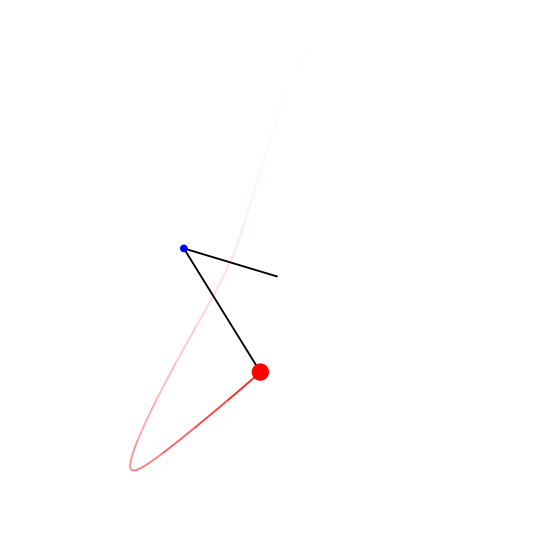

  0%|          | 0/1001 [00:00<?, ?it/s]

In [55]:
%matplotlib notebook
dp.plot("test.gif")

In [219]:
1/dp.dt

Now define $\vec{S} = (\theta_1, z_1, \theta_2, z_2)$.

In [20]:
t = np.linspace(0, 40, 1001)
g = 9.81
m1=2
m2=1
L1 = 2
L2 = 1
ans = odeint(dS_f, y0=[1, -3, -1, 5], t=t, args=(g,m1,m2,L1,L2))

In [21]:
ans

array([[ 1.        , -3.        , -1.        ,  5.        ],
       [ 0.87413906, -3.31025173, -0.78277685,  5.91440903],
       [ 0.73333306, -3.75998052, -0.52139856,  7.24155048],
       ...,
       [-0.54587494,  3.67629747, 85.95938638,  3.00378444],
       [-0.39909083,  3.64659476, 86.10832833,  4.4475008 ],
       [-0.25573142,  3.49832384, 86.3152011 ,  5.89279833]])

In [22]:
the1 = ans.T[0]
the2 = ans.T[2]

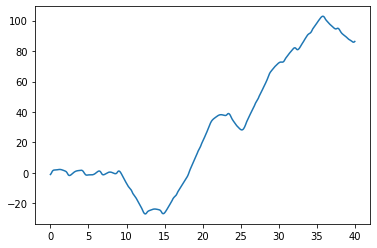

In [23]:
plt.plot(t, the2)

In [24]:
def get_x1y1x2y2(t, the1, the2, L1, L2):
    return (L1*np.sin(the1),
            -L1*np.cos(the1),
            L1*np.sin(the1) + L2*np.sin(the2),
            -L1*np.cos(the1) - L2*np.cos(the2))

x1, y1, x2, y2 = get_x1y1x2y2(t, ans.T[0], ans.T[2], L1, L2)

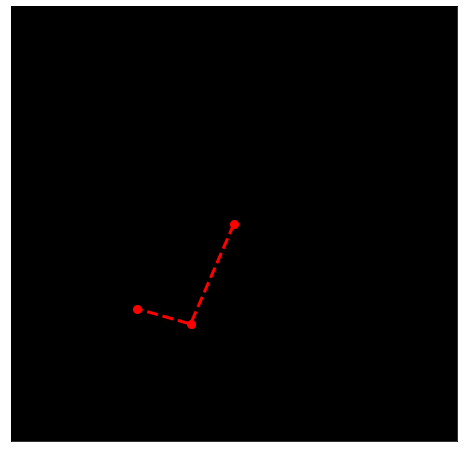

In [25]:
def animate(i):
    ln1.set_data([0, x1[i], x2[i]], [0, y1[i], y2[i]])
    
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.set_facecolor('k')
ax.get_xaxis().set_ticks([])    # enable this to hide x axis ticks
ax.get_yaxis().set_ticks([])    # enable this to hide y axis ticks
ln1, = plt.plot([], [], 'ro--', lw=3, markersize=8)
ax.set_ylim(-4,4)
ax.set_xlim(-4,4)
ani = animation.FuncAnimation(fig, animate, frames=1000, interval=50)
ani.save('pen.gif',writer='pillow',fps=25)

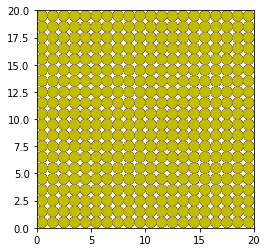

In [32]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation

nx = 20
ny = 20

fig = plt.figure()
plt.axis([0,nx,0,ny])
ax = plt.gca()
ax.set_aspect(1)

def init():
    # initialize an empty list of cirlces
    return []

def animate(i):
    # draw circles, select to color for the circles based on the input argument i. 
    someColors = ['r', 'b', 'g', 'm', 'y']
    patches = []
    for x in range(0,nx):
        for y in range(0,ny):
            patches.append(ax.add_patch( plt.Circle((x+0.5,y+0.5),0.45,color=someColors[i % 5]) ))
    return patches

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=10, interval=20, blit=True)
anim.save('pen.gif',writer='pillow',fps=25)

In [34]:
np.clip(1, 2, 4)

2

In [246]:
a = [1, 2, 3]

def b():
    a[0] = 4

In [247]:
a

In [248]:
b()

In [249]:
a